# Regression Coefficients Nullspace Perspective
This notebook contains contains edamples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
# Fix remaining plots!

# TODO:
# Clean up R and Matlab code
# Go through remianing notebooks and fix d, x issuus

In [2]:
import sys
import os

abspath = r"./src/"
sys.path.append(os.path.abspath(abspath ))

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)

# Custom functions
from hd_data import HD_Data
from basis_function_data import PolynomBasis, construct_data, construct_y_data
from nullspace import Nullspace

from utils import optimise_pls_cv
from plotting_utils import plot_X

%load_ext autoreload
%autoreload 2

In [3]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'

# If outlier should be removed.
remove_outlier = False

# Shall plots be saved?
save_plots = True

# Path to save plots
if remove_outlier:
    save_plot_path = './results/NullspaceNoOutlier/' 
else:
    save_plot_path = './results/Nullspace/'
    # save_plot_path = './../Nullspace/Figures/' 

plt.style.use('./styles/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False


In [4]:
# Create PLS Model objects. 
# You can also used RR or lasso or other models instead.

model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)
model_PLS5 = PLSRegression(n_components=5, tol=1e-7, scale=False)
model_PLS6 = PLSRegression(n_components=6, tol=1e-7, scale=False)

models = [model_PLS1, model_PLS2, model_PLS3, model_PLS4, model_PLS5, model_PLS6]
model_names = ['PLS 1 Comp.', 'PLS 2 Comp.', 'PLS 3 Comp.', 'PLS 4 Comp.', 'PLS 5 Comp.', 'PLS 6 Comp.']

### Example I: Parabolas

In [5]:
if not load_data:
    d_min = 1.0
    d_max = 3.0
    means = np.array([0, 0, 0.3])
    stdv = np.array([0, 0, 0.3])
    n = 50
    p = 201
    d = np.linspace(d_min, d_max, p)[:, None]

    # True feature is the mean
    mean_function = lambda a : np.mean(a)

    # Data without noise
    poly_basis = PolynomBasis(len(means), [d_min, d_max], center=0)
    poly_data = construct_data(poly_basis, mean_function, means, stdv, num_datapoints=p, draws=n, plot_results=1)
    poly_hd_data = HD_Data(X=poly_data.X, d=d, y=poly_data.y)
    # Data with noise
    snr = 50
    poly_hd_data_n = HD_Data(X=poly_data.X.copy(), d=d.copy(), y=poly_data.y.copy()).add_wgn(snr_x=snr, snr_y=snr)

    if save_data: 
        np.savetxt(
            data_path + "poly_hd_data.csv", np.hstack((poly_hd_data.X, np.expand_dims(poly_hd_data.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {n}, sample mean, no noise \n d = {d.T}")
        np.savetxt(
            data_path + "poly_hd_data_n.csv", np.hstack((poly_hd_data_n.X, np.expand_dims(poly_hd_data_n.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {n}, sample mean, added noise, snr = {snr} \n d = {d.T}")
else: 
    temp = np.loadtxt(data_path + "poly_hd_data.csv", skiprows=1, delimiter=",") 
    temp_n = np.loadtxt(data_path + "poly_hd_data_n.csv", skiprows=1, delimiter=",") 
    # Parameters from header ofcsv file
    d = np.linspace(1.0, 3.0, temp[:,:-1].shape[1])[:, None]

    poly_hd_data = HD_Data(X=temp[:,:-1], d=d, y=temp[:,-1]) 
    poly_hd_data_n = HD_Data(X=temp_n[:,:-1], d=d, y=temp_n[:,-1]) 

mean_reg_coef = (1/poly_hd_data.X.shape[1]) * np.ones(poly_hd_data.X.shape[1])

Constraint value: 0.000000000000, Method NRMSE
Constraint value: 1.8615979555616872e-15, is too close to the numeric precision for path analysis


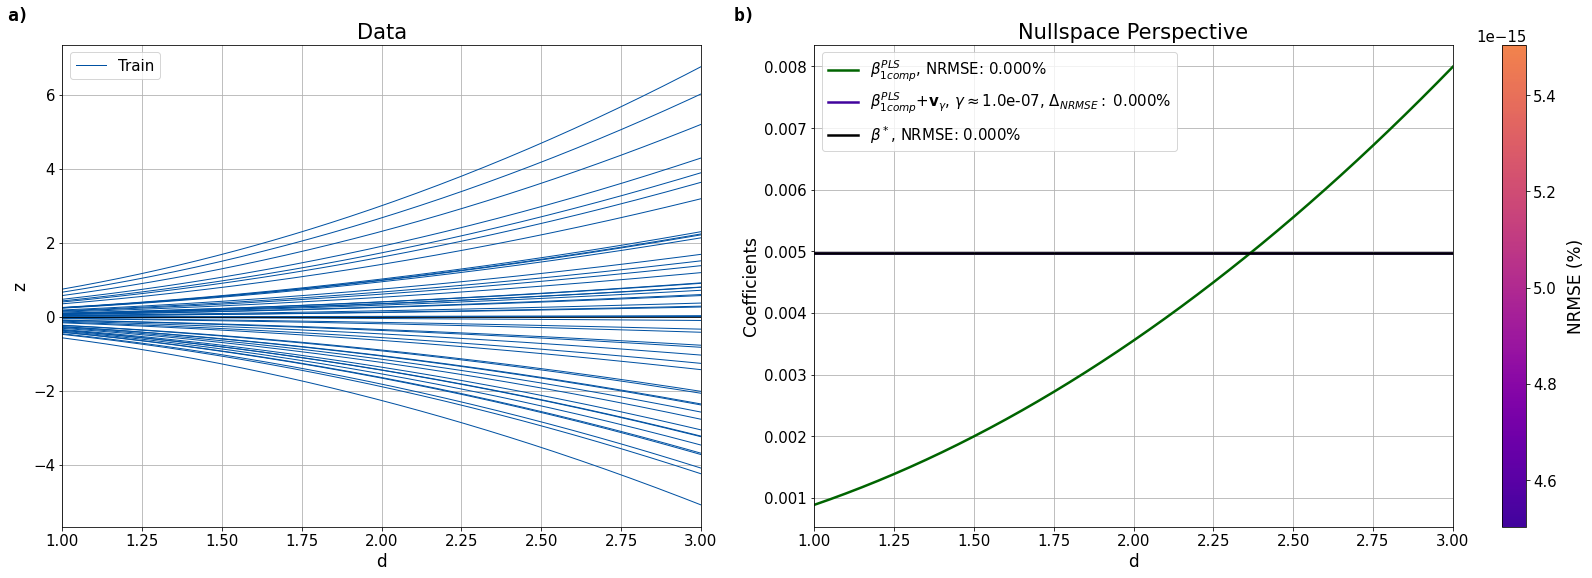

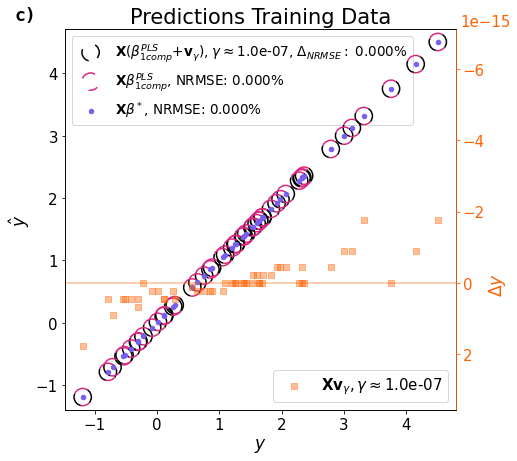

In [8]:
nulls_parab = Nullspace(poly_hd_data)
nulls_parab = nulls_parab.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab.set_standardization(std=False)

nulls_parab.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name=r'$\beta_{1 comp}^{PLS}$',
    w_beta = mean_reg_coef, 
    w_beta_name=r'$\beta^*$'
    )

nulls_parab, fig, ax = nulls_parab.nullspace_analysis(
    nullspace_path = False, 
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name='Polynomial_example.pdf', 
    opt_gamma_method='NRMSE', 
    con_thres=10**(-13),
    )
ax[0].set_ylabel('z')
ax[0].set_xlabel('d')
ax[1].set_xlabel('d')    

kwargs_scatter = {"y_coords" : [1.08, 0.33], "ax_labelstr" : "c)"}
nulls_parab.scatter_predictions(title="Predictions Training Data", **kwargs_scatter)

Constraint value: 0.000661250076


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:241: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.max_gamma = gamma


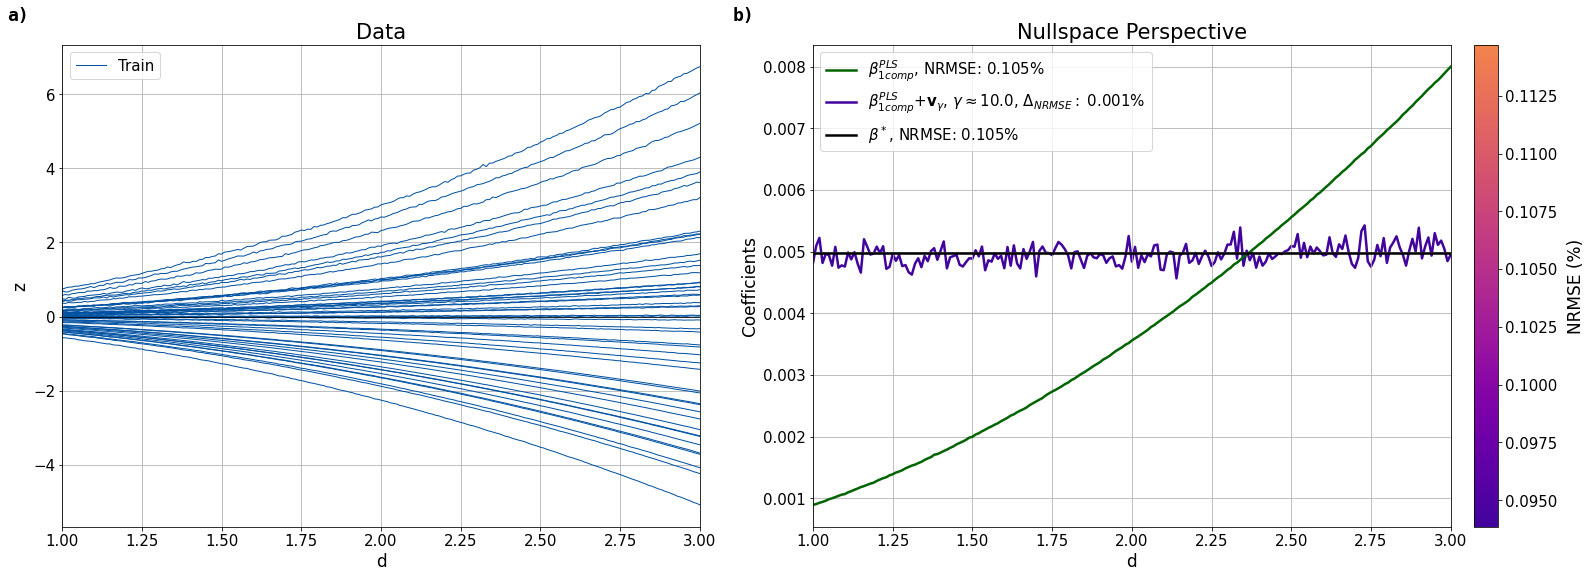

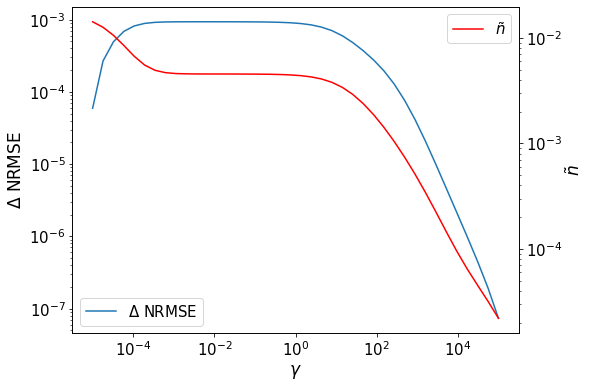

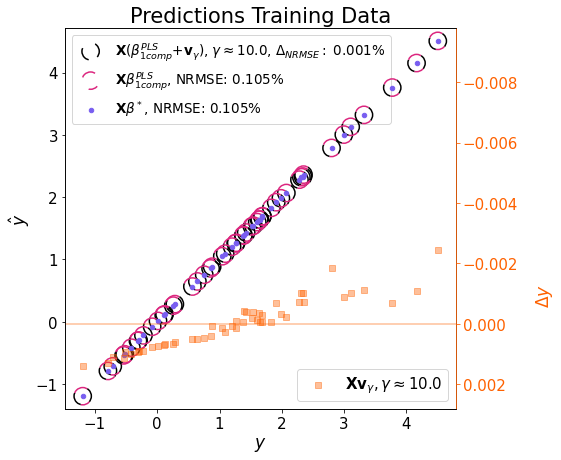

In [11]:
nulls_parab_n = Nullspace(poly_hd_data_n)
nulls_parab_n = nulls_parab_n.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab_n.set_standardization(std=False)

nulls_parab_n.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name=r'$\beta_{1 comp}^{PLS}$',
    w_beta = mean_reg_coef, 
    w_beta_name=r'$\beta^*$'
    )
    
nulls_parab_n, fig, ax = nulls_parab_n.nullspace_analysis(
    nullspace_path = False,
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name='Polynomial_example_noise.pdf', 
    opt_gamma_method='NRMSE', 
    ax_labelstr = ("a)", "b)"),
    gamma_vals = [10],
    )
ax[0].set_ylabel('z')
ax[0].set_xlabel('d')
ax[1].set_xlabel('d')


kwargs_scatter = {"y_coords" : [1.2, 0.3]}
nulls_parab_n.scatter_predictions(title="Predictions Training Data", ax_labelstr="", **kwargs_scatter)

In [ ]:
# include one with the fused elastic net. 
# include to insert gamma directly.
# Compare the fused lasso results with PLS wiht more components!

# Example using LFP Data:

published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

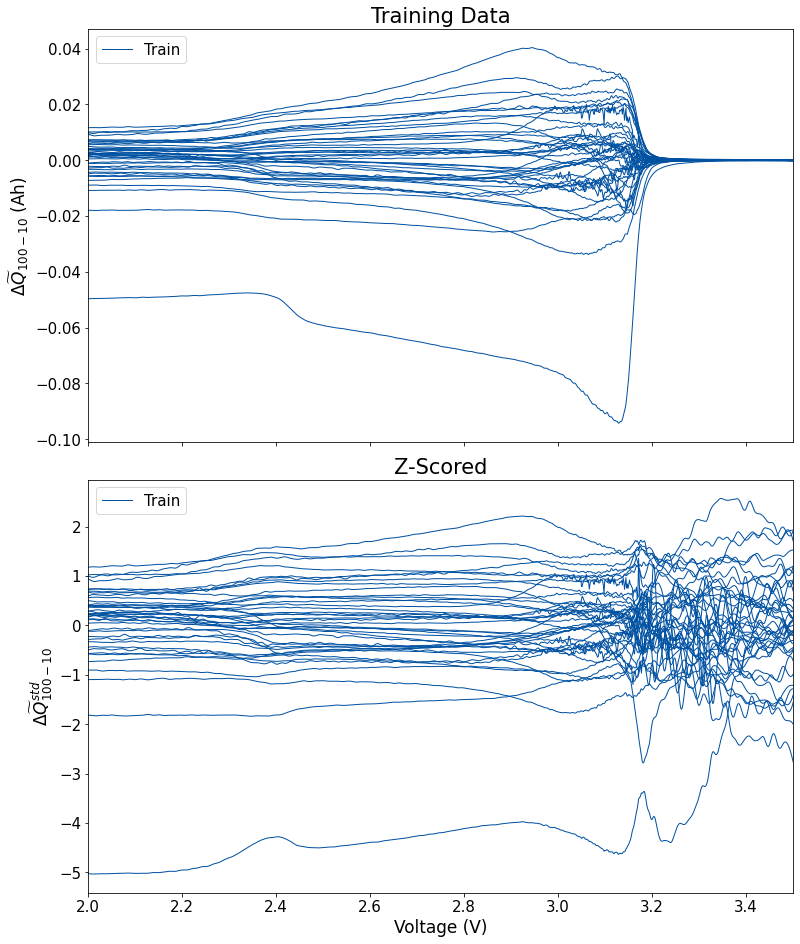

In [8]:
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
d_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
# X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
# y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
# X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
# y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

fig, ax = plot_X(X_lfp_train, d_lfp)
if save_plots: 
    fig.savefig(save_plot_path + 'TrainingData.pdf') 

# Remove outlier 


In [9]:
if remove_outlier:
    id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
    X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
    y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

    fig, ax = plot_X(X_lfp_train, d_lfp, ax0_title='Training Data (outlier removed)', ax1_title='Z-Scored')
    if save_plots: 
        fig.savefig(save_plot_path + 'TrainingDataOutlierRemoved.pdf') 

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_mean_function = construct_y_data(X_lfp_train, mean_function, per_range=[0,1])
    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfp_train_mean_function)
    data_lfp_mean = data_lfp_mean.add_wgn(snr_y=50)

    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_mean.csv', data_lfp_mean.y, delimiter=",", 
            header='Sample Mean reposne for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_mean.csv', skiprows=1, delimiter=',')
    if remove_outlier: 
        y = np.delete(y, id_outlier, axis=0)

    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

In [10]:
# LFP dataset synthethic y
nulls_lfp = Nullspace(data_lfp_mean)
nulls_lfp = nulls_lfp.learn_weights(models, model_names)
nulls_lfp.set_standardization(std=False)

{'rmse_vals': array([1.84705362e-07, 2.85884026e-08, 8.62257071e-09, 9.05112543e-09,
        9.77562548e-09, 7.12198366e-09, 4.88343439e-09, 5.74335604e-09,
        5.12685925e-09, 6.01456320e-09]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

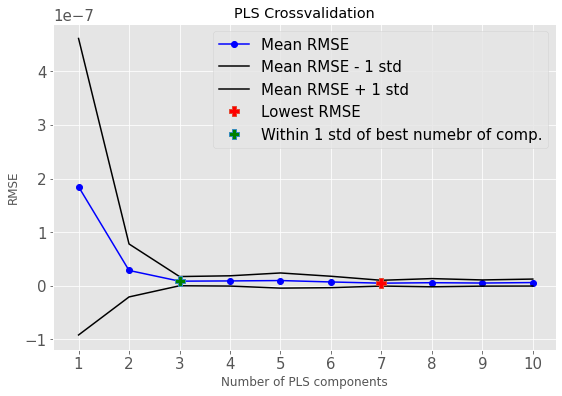

In [11]:
optimise_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=False)

{'rmse_vals': array([6.97256699e-07, 2.41753668e-07, 3.31935169e-08, 2.06174936e-08,
        1.20283742e-08, 4.47011891e-09, 3.22890259e-09, 2.00406810e-09,
        2.39660539e-09, 1.97205282e-09]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 6,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

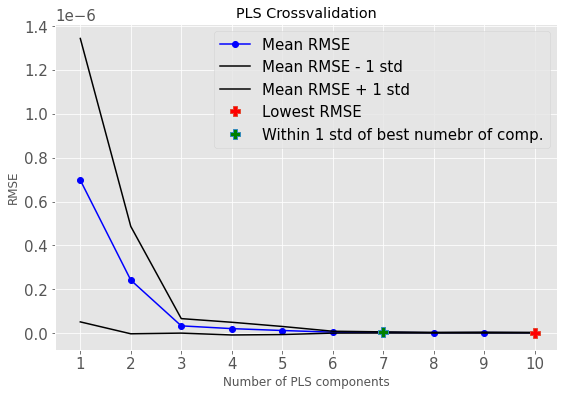

In [12]:
optimise_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=True)

In [13]:
if 0:
    nulls_lfp.set_standardization(std=True)
    nulls_lfp.set_nullspace_weights(
        key_alpha = 'PLS 1 Comp.', 
        w_alpha_name='PLS 1 Component', 
        w_beta = mean_reg_coef_lfp, 
        w_beta_name='Mean Weights'
        )
    nulls_lfp, nrmse, gamma_vals = nulls_lfp.nullspace_analysis(
        plot_results=False, save_plot=0, opt_gamma_method='NRMSE', con_thres=0)

NRMSE constraint threshold:  0.1906490925203975
Constraint value: 0.190649192521, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


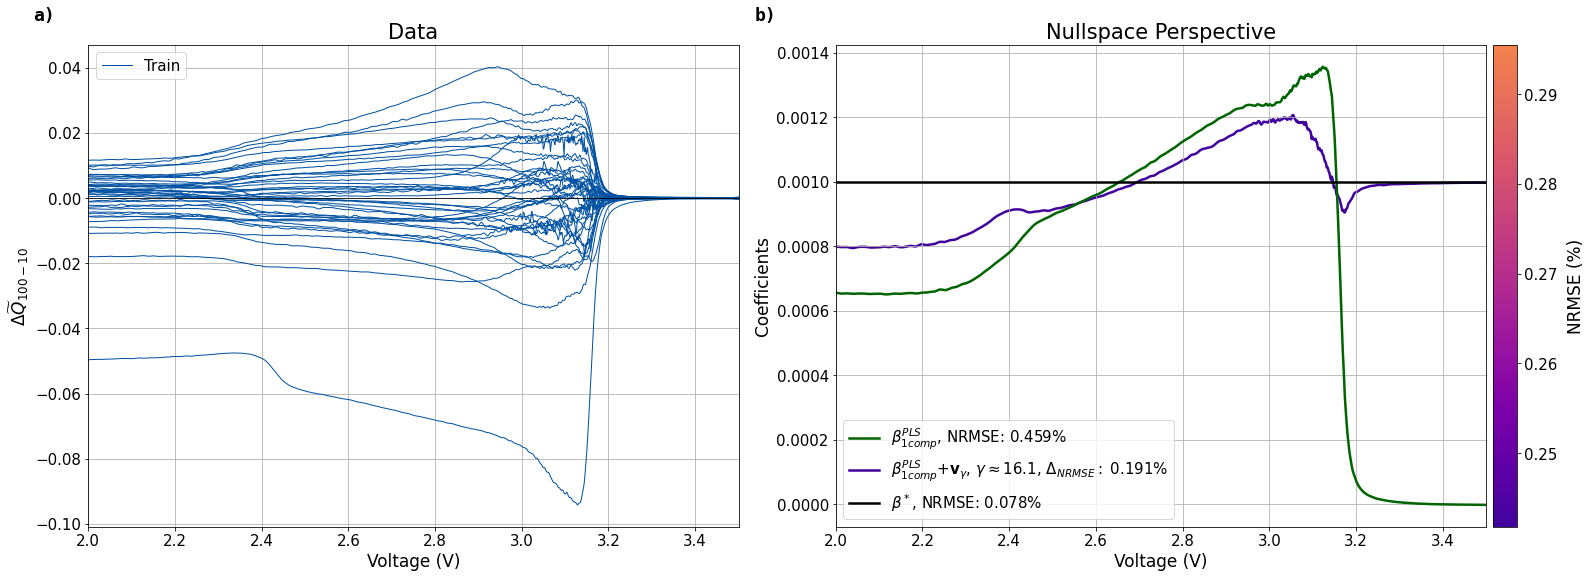

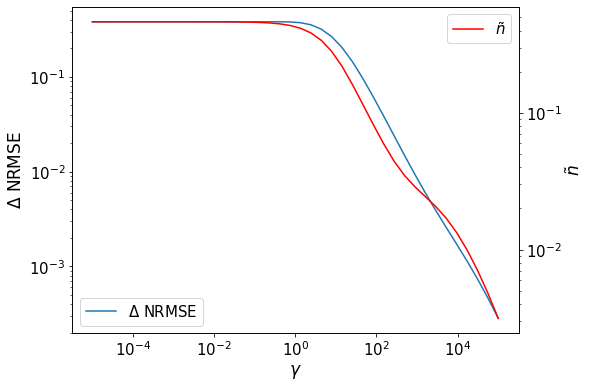

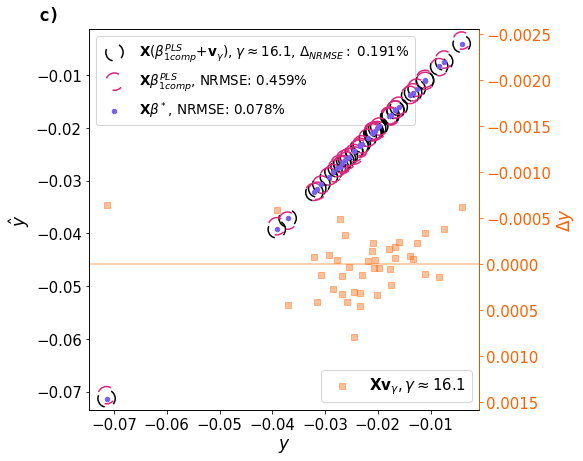

In [14]:
nulls_lfp.set_standardization(std=False)
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name=r'$\beta_{1 comp}^{PLS}$',
    w_beta = mean_reg_coef_lfp, 
    w_beta_name=r'$\beta^*$'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    nullspace_path = False,
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=-0.5,
    )
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_PLS_mean.pdf') 

# Check how these predicitons get in there...
nulls_lfp.scatter_predictions()

Constraint value: 0.080000099949, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


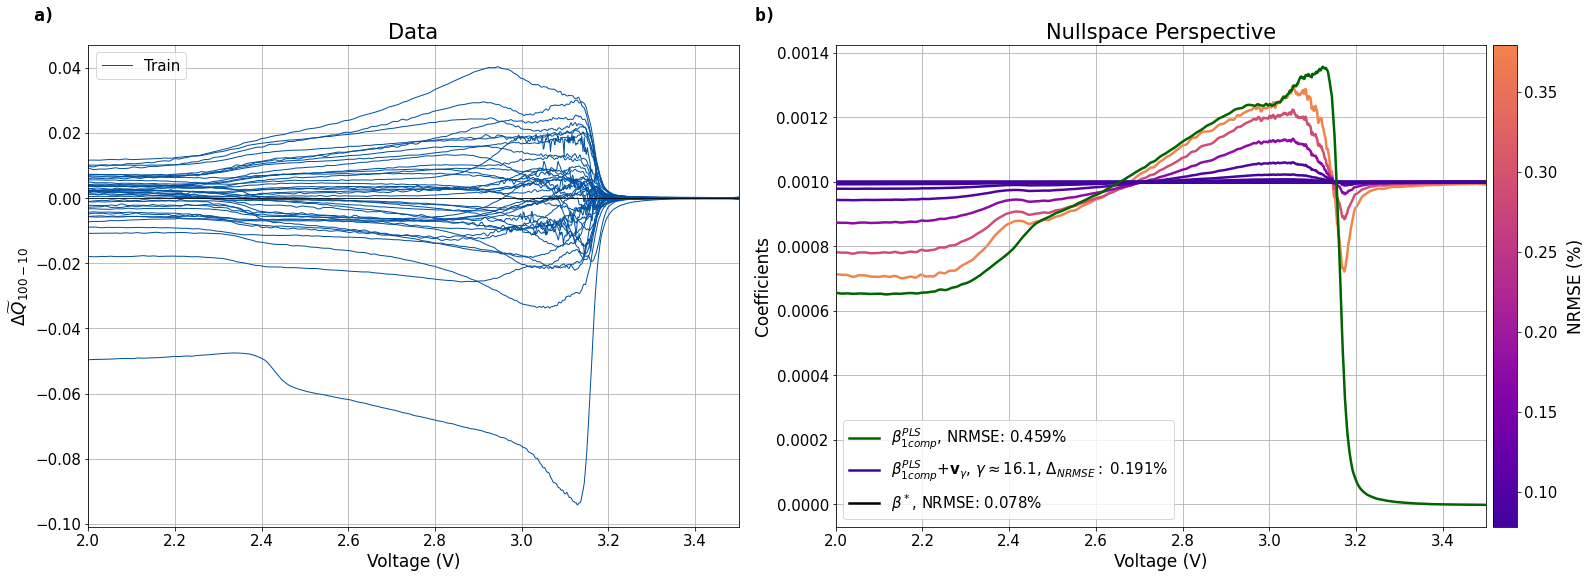

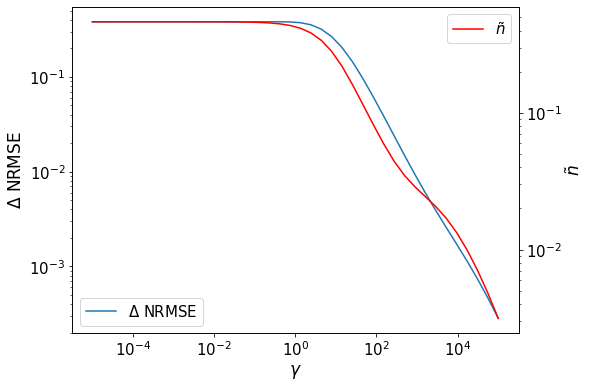

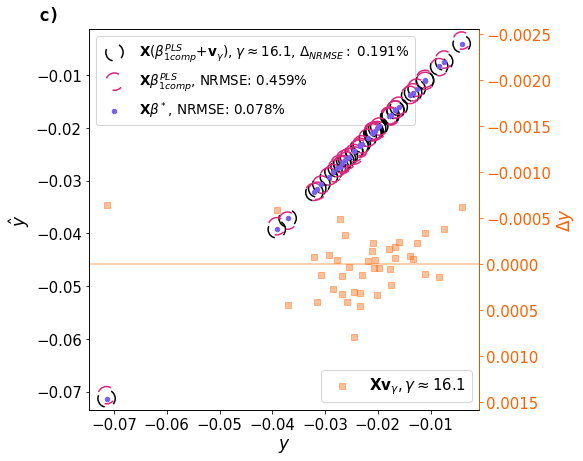

In [15]:
nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.08)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_PLS_mean_.pdf') 

nulls_lfp.scatter_predictions()

Constraint value: 0.010000100019, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


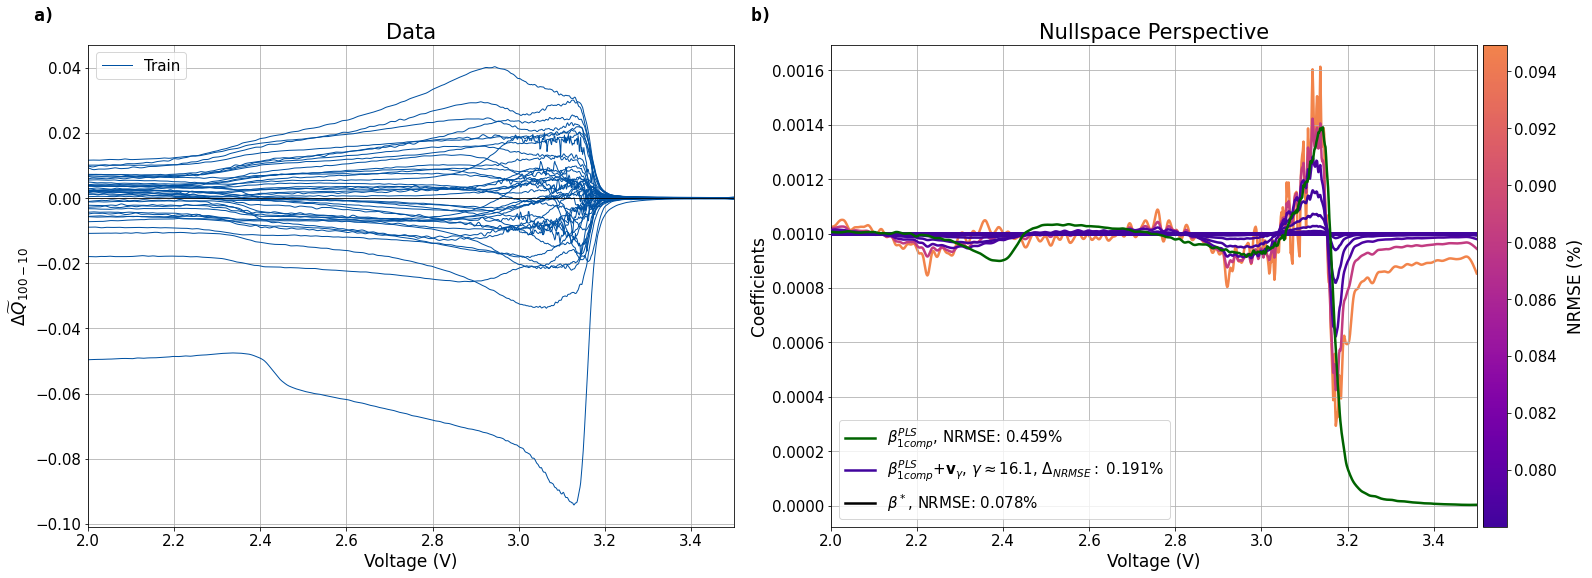

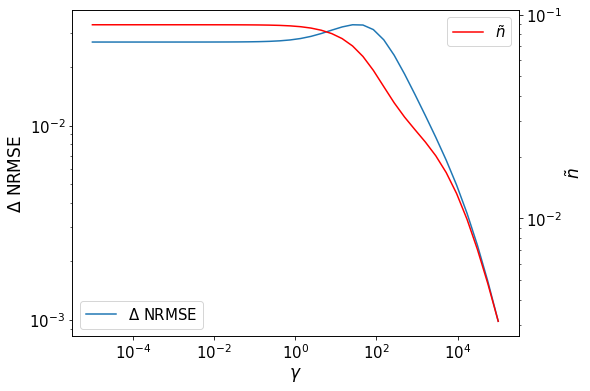

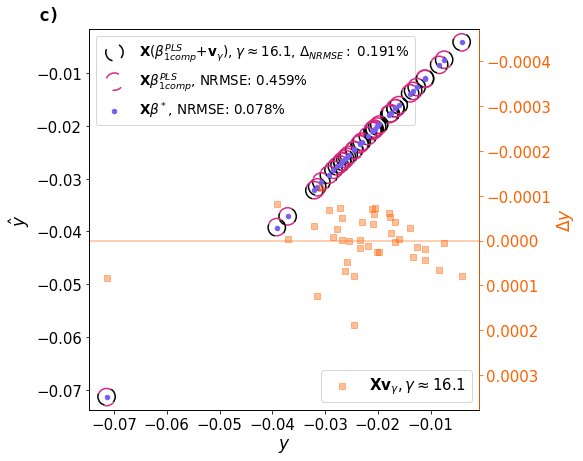

In [16]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name='PLS 3 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.01)


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_3PLS_mean.pdf')

nulls_lfp.scatter_predictions()

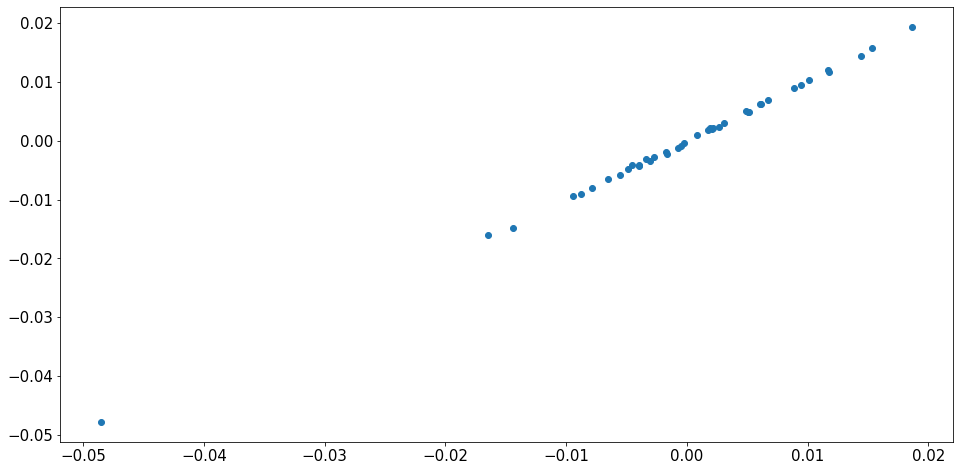

In [17]:
plt.scatter(nulls_lfp.X@mean_reg_coef_lfp, nulls_lfp.X@nulls_lfp.weights['PLS 1 Comp.']+nulls_lfp.X@nulls_lfp.nullsp['v_'][-1, :])

NRMSE constraint threshold:  0.01029922613627559
Constraint value: 0.010299326136, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


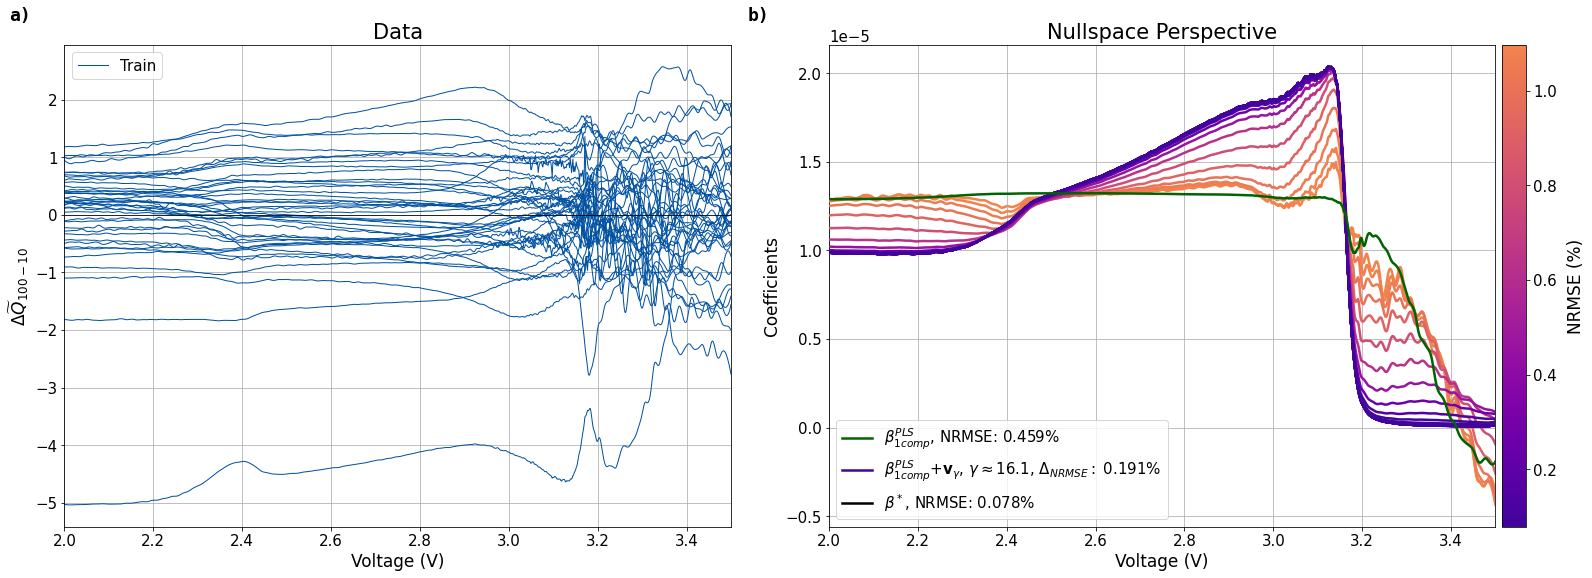

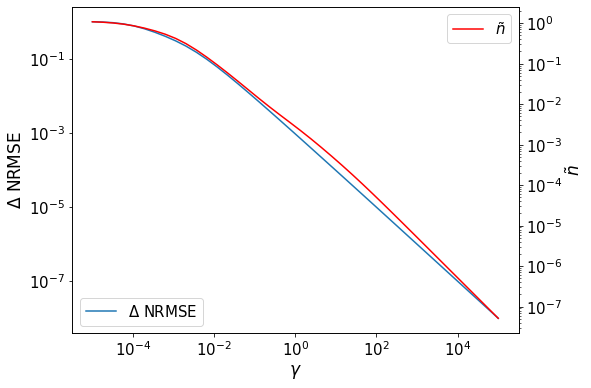

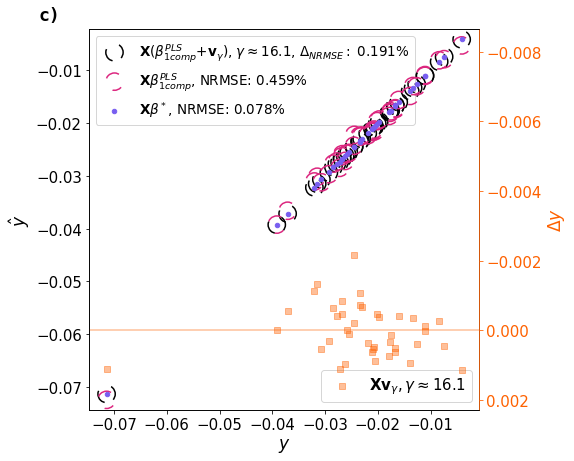

In [18]:
nulls_lfp.set_standardization(std=True)
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )
nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.01)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_1PLS_mean.pdf')

nulls_lfp.scatter_predictions()

NRMSE constraint threshold:  0.23504462641804486

Optimization took 13.79 seconds

Optimization depth: 29, max depth: 30

Gamma value corresponding to 2.4e-01 % is 0.0022146719233808324

Constraint value: 0.235

1.0000111207011153e-07

Scipy Optimization took 13.31 seconds

Constraint value: 0.235044725570, Method NRMSE


In [19]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name='PLS 2 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_3PLS_mean.pdf')

nulls_lfp.scatter_predictions()

NRMSE constraint threshold:  0.2712074175948751


KeyboardInterrupt: 

Constraint value: 0.000500099997, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


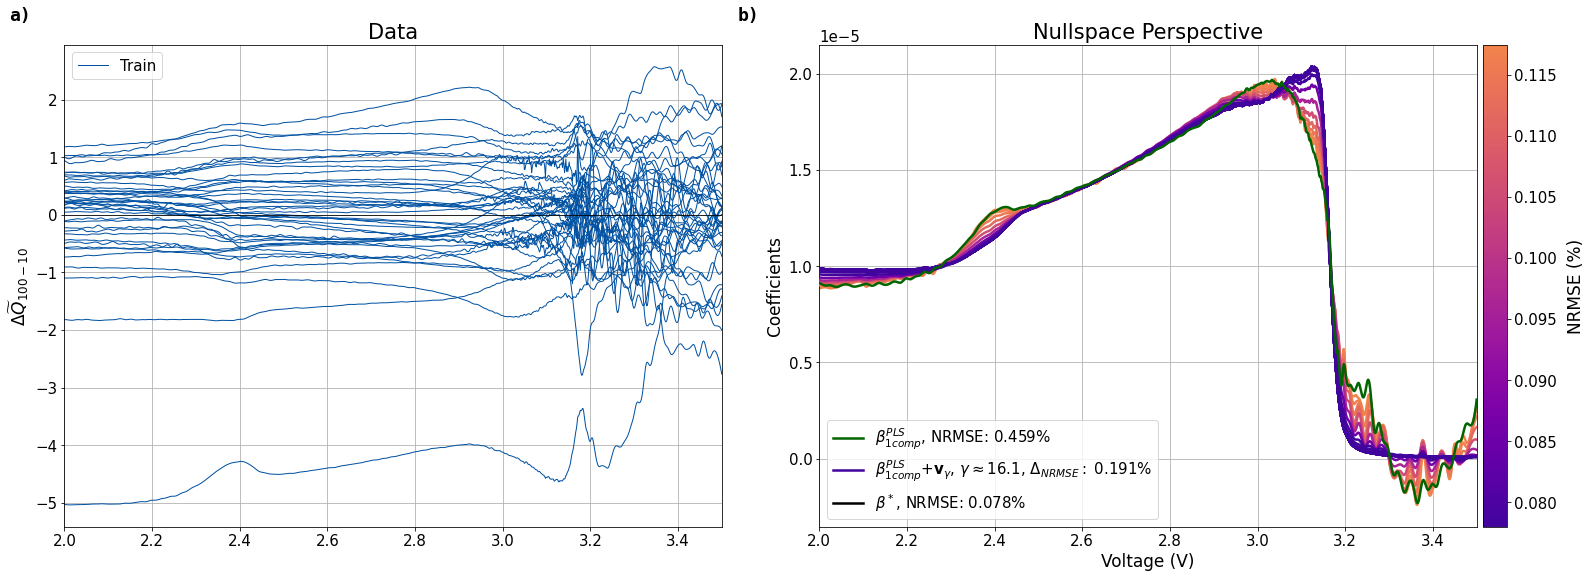

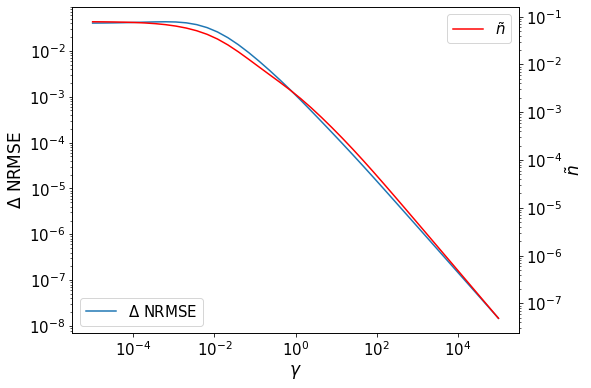

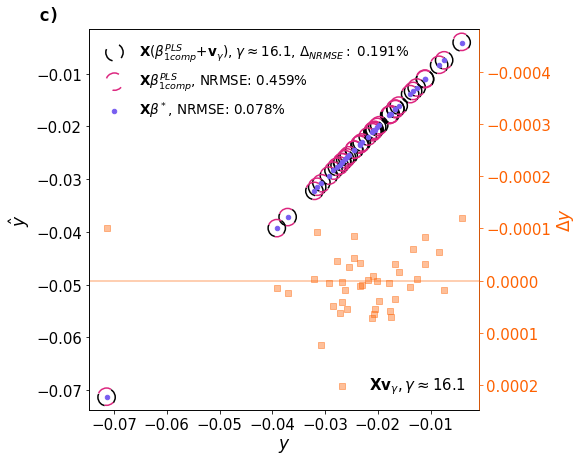

In [ ]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 4 Comp.', 
    w_alpha_name='PLS 4 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.0005)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')   
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')


nulls_lfp.scatter_predictions()

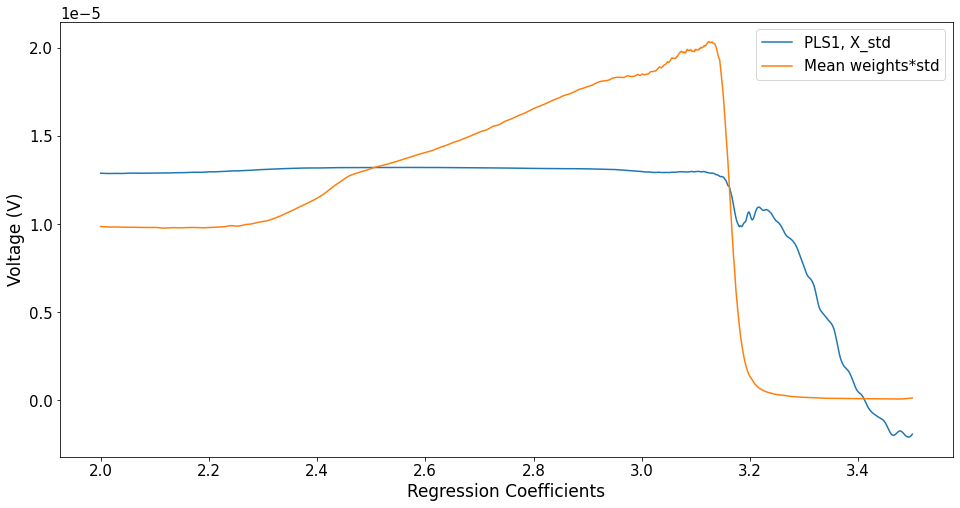

In [ ]:
if 1:
    plt.plot(nulls_lfp.data.d, nulls_lfp.weights['PLS 1 Comp. std'], label='PLS1, X_std')
    plt.plot(nulls_lfp.data.d, mean_reg_coef_lfp*nulls_lfp.data.stdx, label='Mean weights*std')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Regression Coefficients')
    plt.legend()
    plt.show()

### Colum mean weights

In [ ]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(snr_y=50)
    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_cm.csv', dml_lfps_cm.y, delimiter=',', 
            header='Column Mean response for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_cm.csv', skiprows=1, delimiter=',')
    if remove_outlier: 
        y = np.delete(y, id_outlier, axis=0)
    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

nulls_lfp_cm = Nullspace(dml_lfps_cm)
nulls_lfp_cm = nulls_lfp_cm.learn_weights(models, model_names)

{'rmse_vals': array([8.43610691e-05, 2.08823982e-05, 1.04717945e-05, 9.75816840e-06,
        7.83045217e-06, 1.03797241e-05, 1.09636014e-05, 1.31673070e-05,
        2.29677563e-05, 3.04014771e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

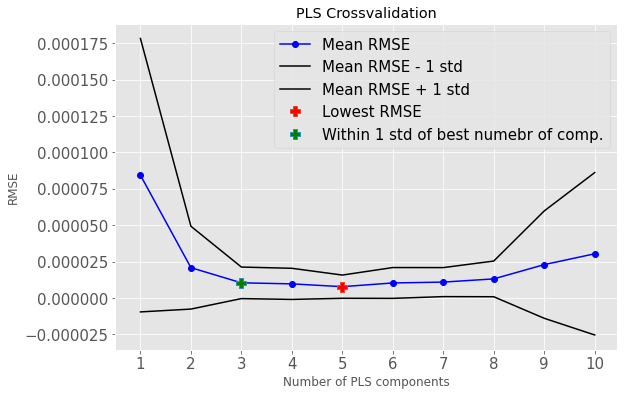

In [ ]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

{'rmse_vals': array([1.91559611e-03, 1.03456898e-03, 8.42962893e-05, 3.12962529e-05,
        9.44446398e-06, 1.16567141e-05, 1.37699651e-05, 1.51333231e-05,
        1.24753666e-05, 1.48378551e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 4,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

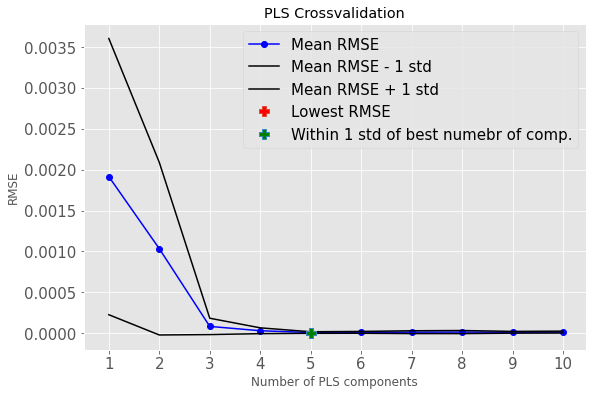

In [ ]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

NRMSE constraint threshold:  0.008741262930692183
Constraint value: 0.008741362927, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


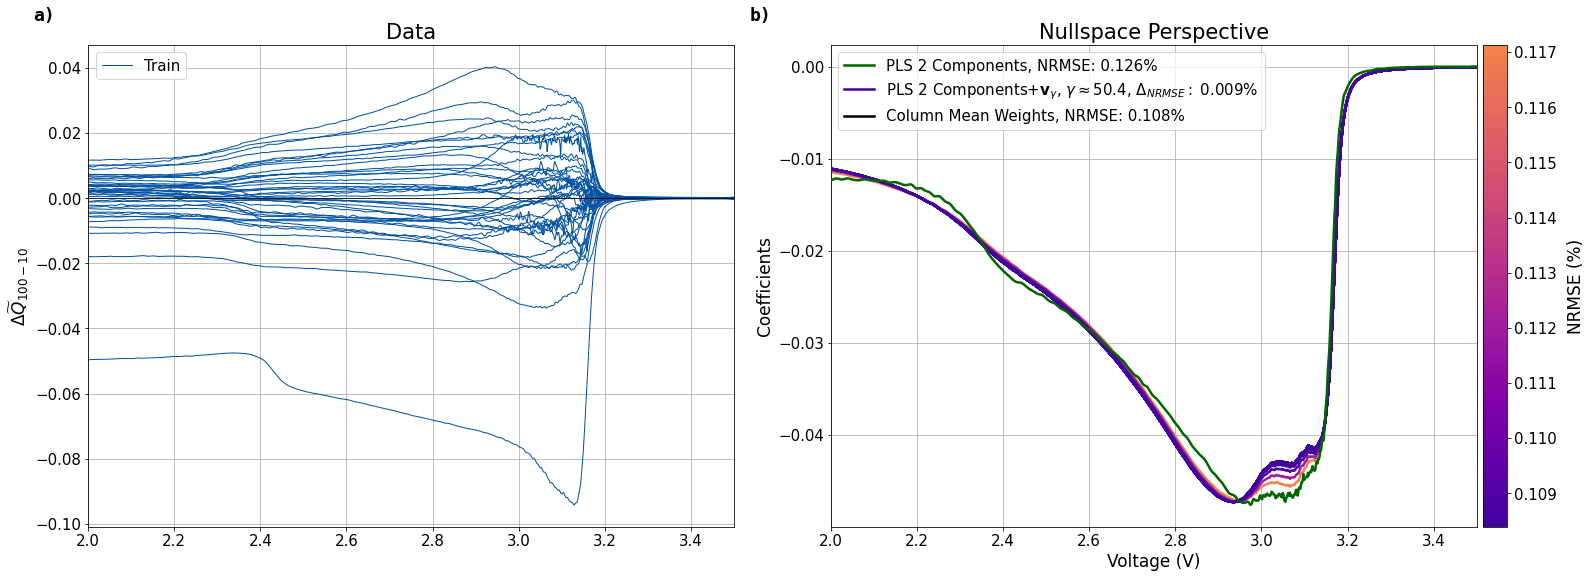

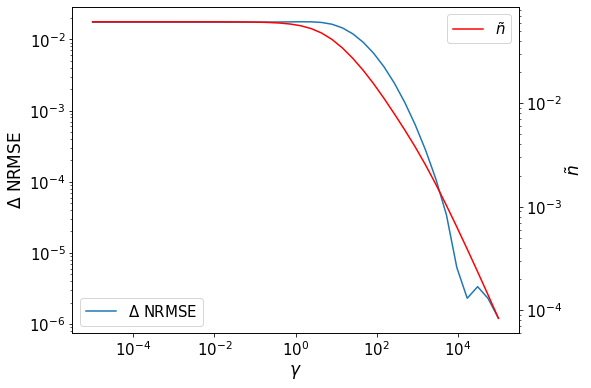

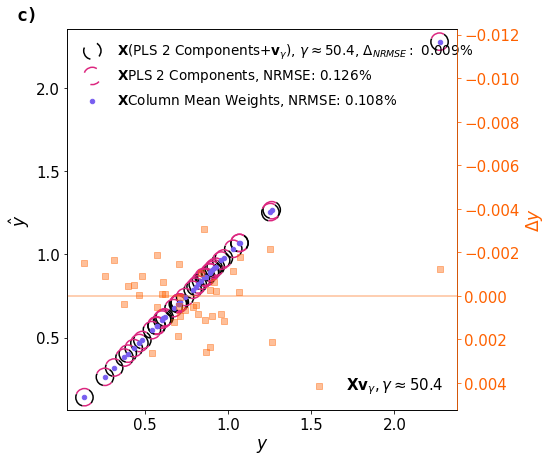

In [ ]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name='PLS 2 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )
nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_2PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.0009325479734866443
Constraint value: 0.000932647972, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


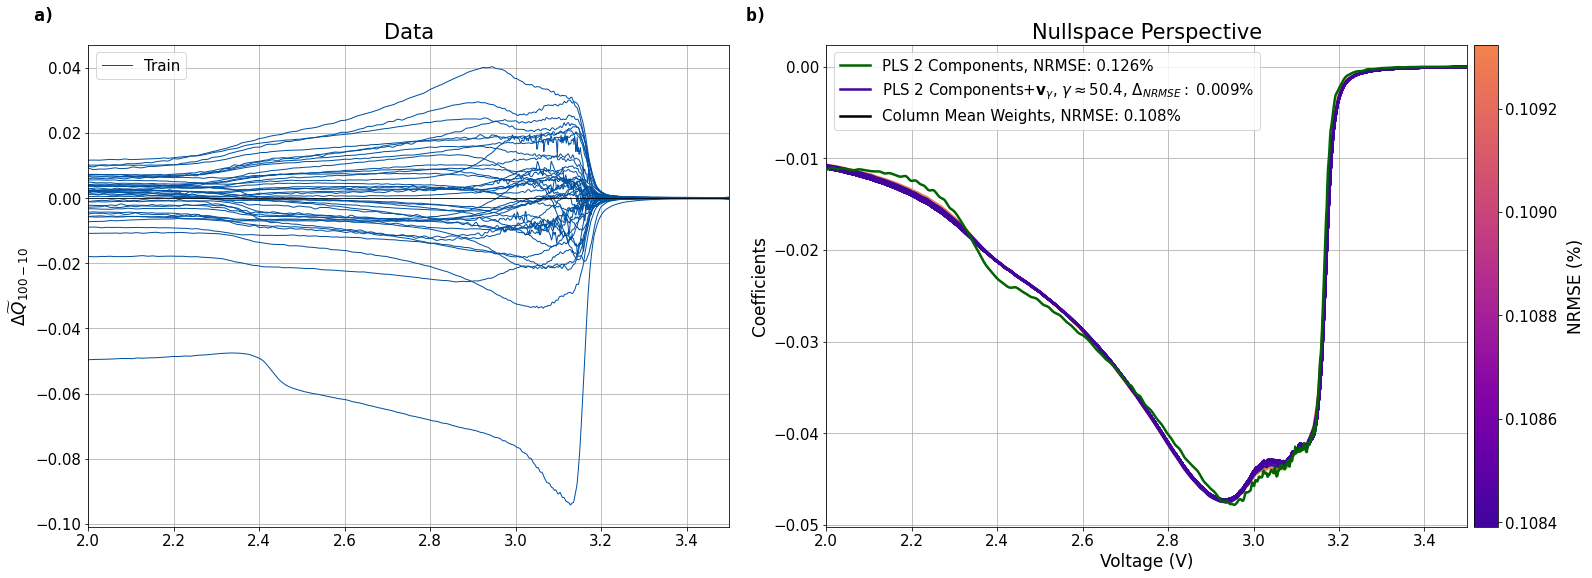

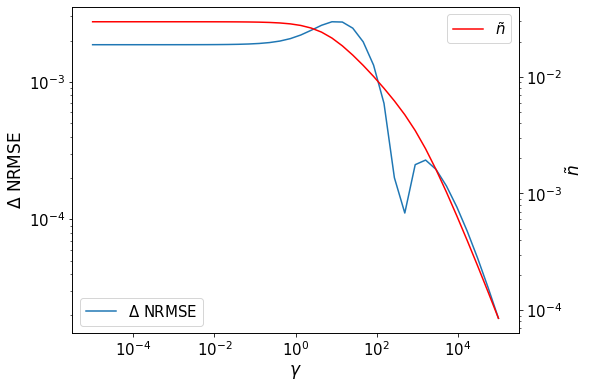

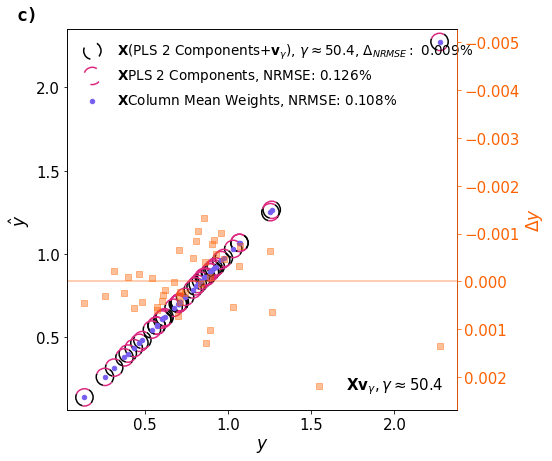

In [ ]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name='PLS 3 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_3PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.002014166429718793
Constraint value: 0.002014266431, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


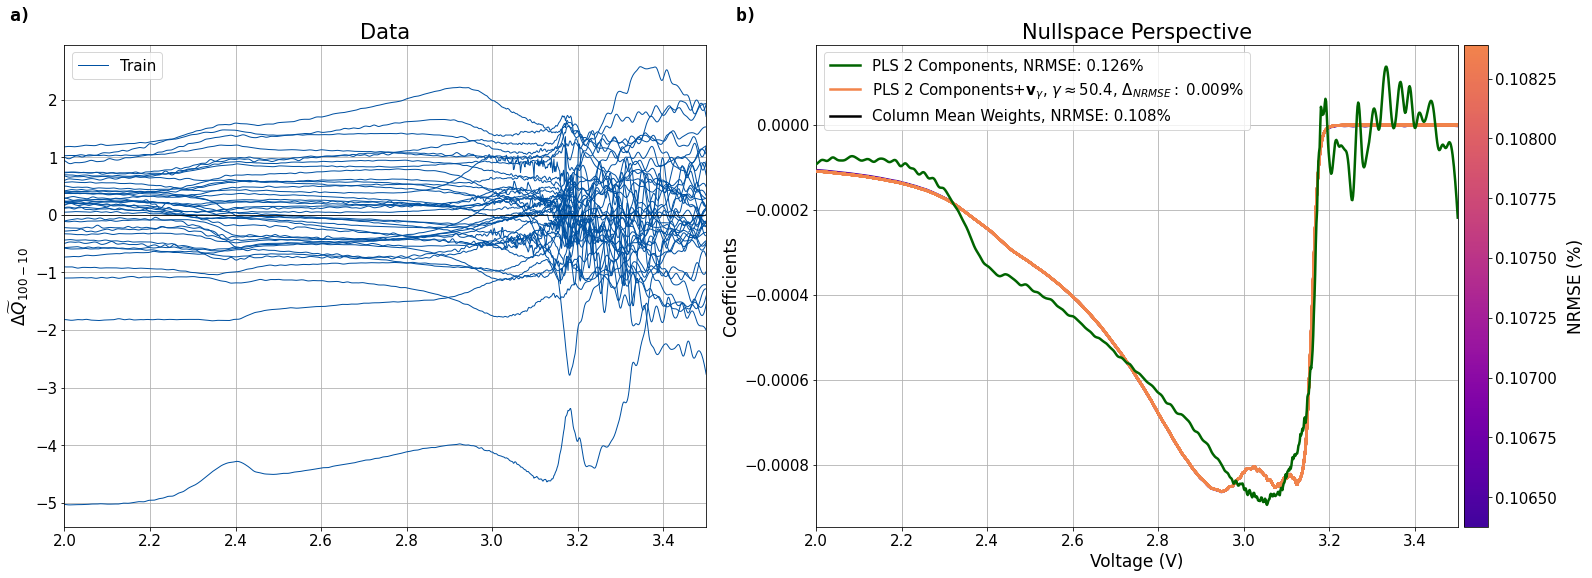

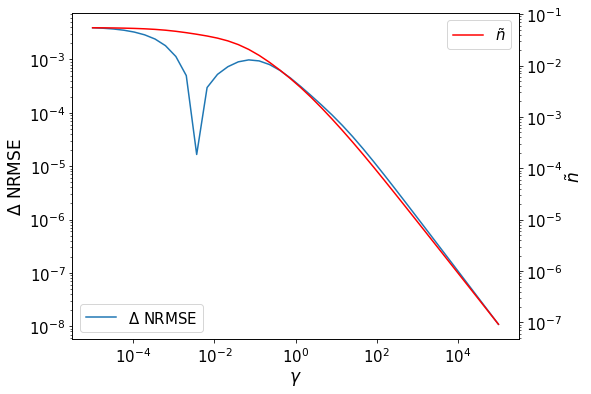

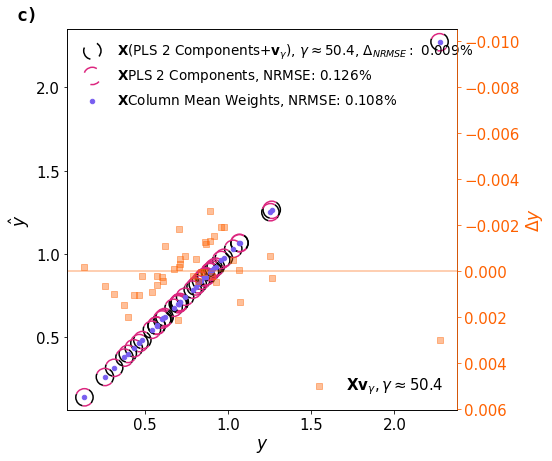

In [ ]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 5 Comp.', 
    w_alpha_name='PLS 5 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_5PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

In [ ]:
range_y_cm = np.max(nulls_lfp_cm.data.y_)-np.min(nulls_lfp_cm.data.y_)

In [ ]:
range_y_cm

2.131085308303401

0.10828441942343277
0.10839091767911697
0.10436258481967939


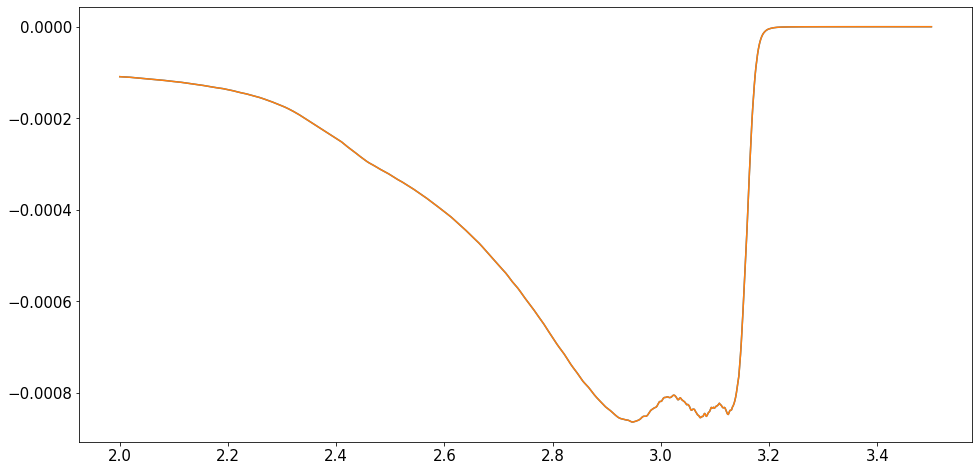

In [ ]:
plt.plot(nulls_lfp_cm.data.d, nulls_lfp_cm.nullsp['w_alpha_std']+nulls_lfp_cm.nullsp['v_'][-1, :])
plt.plot(nulls_lfp_cm.data.d, nulls_lfp_cm.nullsp['w_beta_std'])

# calucleate NRMSE
from sklearn.metrics import mean_squared_error
range_y_cm = np.max(nulls_lfp_cm.data.y_)-np.min(nulls_lfp_cm.data.y_)
print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_alpha_std']+nulls_lfp_cm.nullsp['v_'][-1, :]), squared=False)/range_y_cm)
print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_beta_std']), squared=False)/range_y_cm)
print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_alpha_std']), squared=False)/range_y_cm)

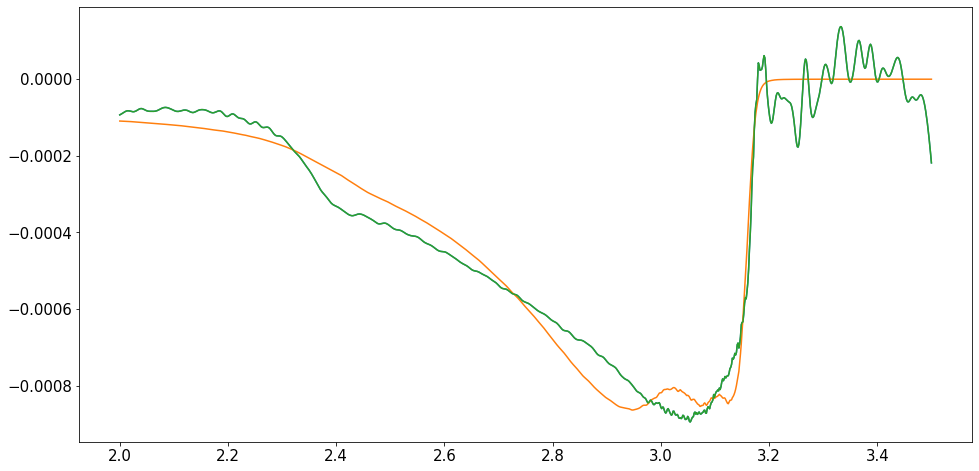

In [ ]:
plt.plot(nulls_lfp_cm.data.d, nulls_lfp_cm.weights['PLS 5 Comp. std'], label='PLS5, X_std')
plt.plot(nulls_lfp_cm.data.d, rcoef_lfp_cm*nulls_lfp_cm.data.stdx, label='Column Mean weights*std')
plt.plot(nulls_lfp_cm.data.d, rcoef_lfp_cm*nulls_lfp_cm.data.stdx - nulls_lfp_cm.nullsp['v_'][-1, :].reshape(-1), label='Column Mean weights*std')
# plt.plot(nulls_lfp_cm.data.d, nulls_lfp_cm.nullsp['w_alpha'], label='')

NRMSE constraint threshold:  0.003767603524025054
Constraint value: 0.003767703525, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


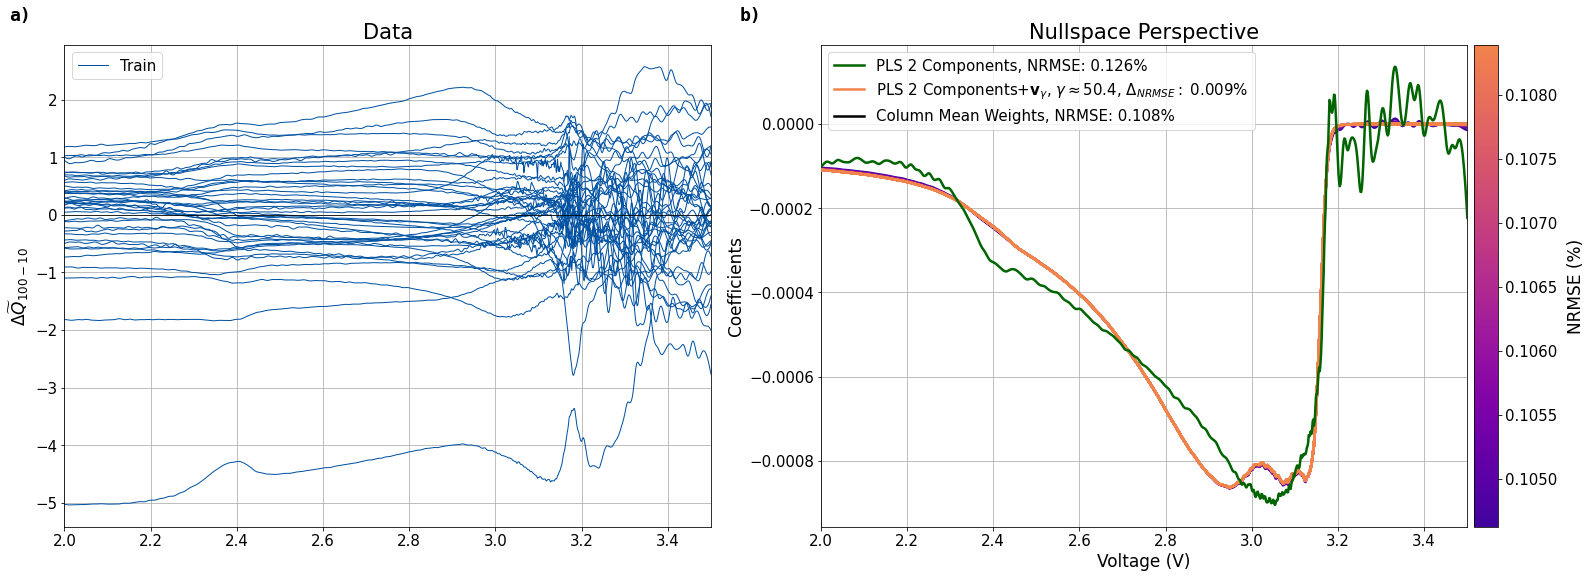

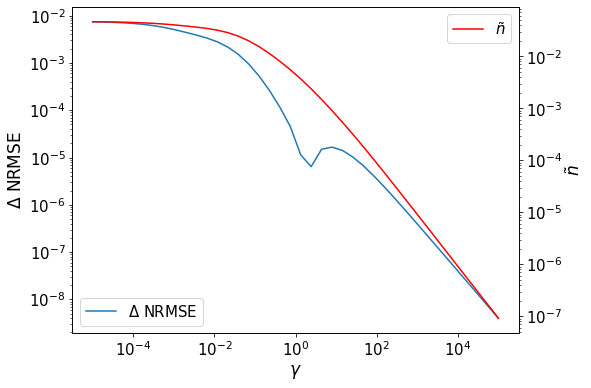

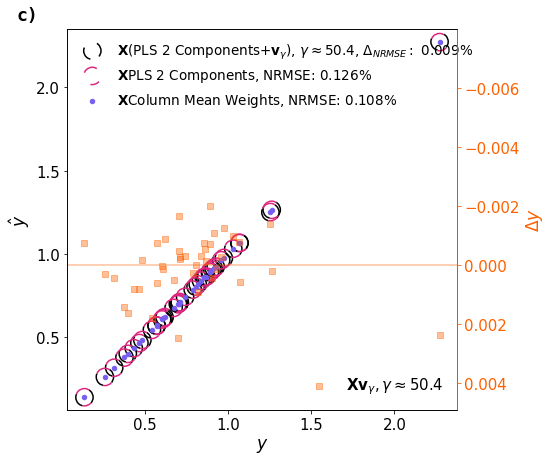

In [ ]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 6 Comp.', 
    w_alpha_name='PLS 6 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_6PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.007459854977569606
Constraint value: 0.007459954958, Method NRMSE


/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/nullspace.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


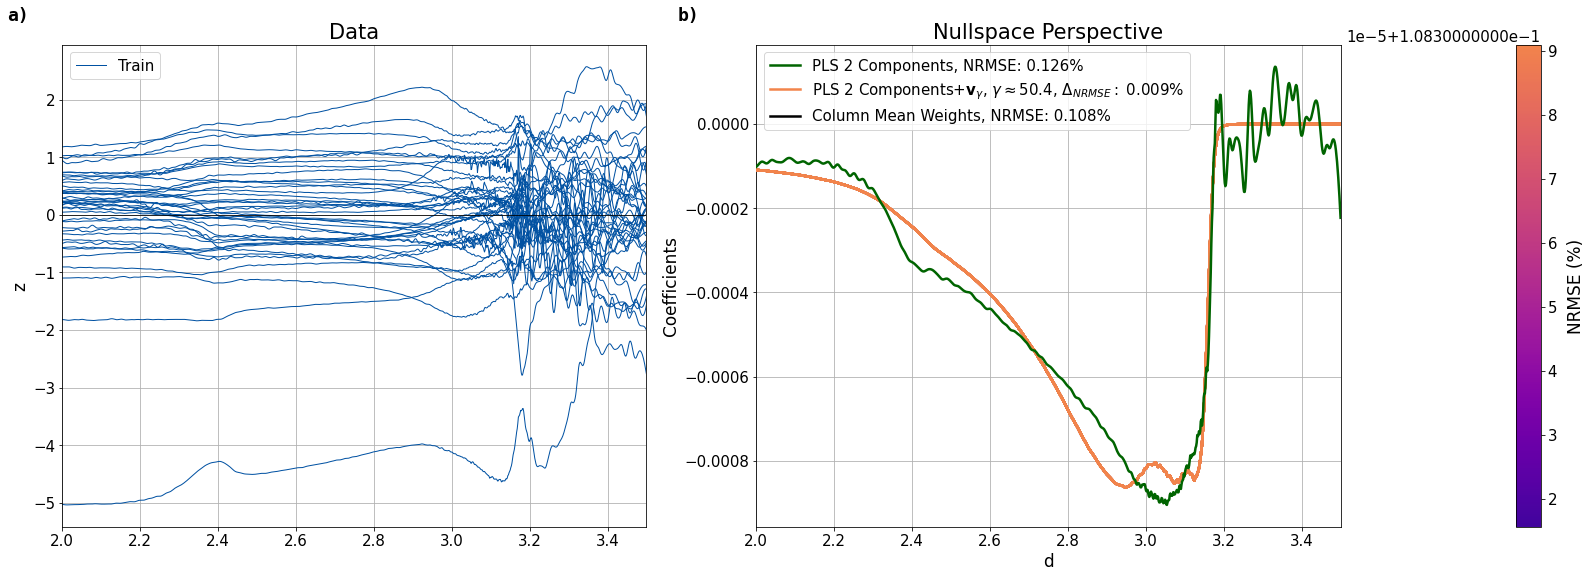

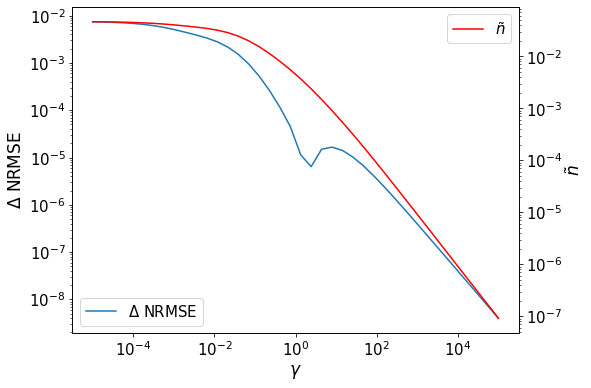

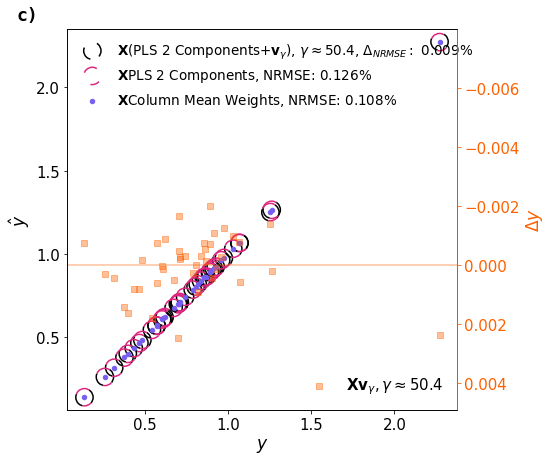

In [ ]:
nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0,  opt_gamma_method='NRMSE', con_thres=-0.99)

nulls_lfp_cm.scatter_predictions()